In [8]:
import os
import time
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("Taxi-v3", render_mode="ansi")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Memory
We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we’re going to need two classses:

`Transition` - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.

`ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.rng = np.random.default_rng()

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        idx = self.rng.choice(np.arange(len(self.memory)), batch_size, replace=False)
        res = []
        for i in idx:
            res.append(self.memory[i])
        return res

    def __len__(self):
        return len(self.memory)

# Q-network
Our model will be a convolutional neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing Q(s,left) and Q(s,right) (where s is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.

In [10]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.embedding = nn.Embedding(n_observations, 4)
        self.layer1 = nn.Linear(4, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x): 
        x = F.relu(self.layer1(self.embedding(x)))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Training
## Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some utilities:

- `select_action` - will select an action accordingly to an epsilon greedy policy. Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. The probability of choosing a random action will start at `EPS_START` and will decay exponentially towards `EPS_END`. `EPS_DECAY` controls the rate of the decay.

- `plot_durations` - a helper for plotting the durations of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). The plot will be underneath the cell containing the main training loop, and will update after every episode.

In [11]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 400
TAU = 0.005
LR = 1e-3

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()

# Number of observations is the number of states Taxi-v3 has 500
n_observations = env.observation_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

if os.path.isfile('policy_net.pth'):
    policy_net.load_state_dict(torch.load('policy_net.pth'))
    print('Load policy_net.pth')
    
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def get_action_for_state(state):
    with torch.no_grad():
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        predicted = policy_net(torch.tensor([state], device=device))
        action = predicted.max(1)[1]
    return action

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    if sample > eps_threshold:
        return get_action_for_state(state)
    else:
        return env.action_space.sample()


episode_durations = []
reward_history = []
epsilons = []

def _moving_average(x, periods=5):
    if len(x) < periods:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    res = (cumsum[periods:] - cumsum[:-periods]) / periods
    return np.hstack([x[:periods-1], res])


def plot_durations():
    lines = []
    fig = plt.figure(1, figsize=(15, 7))
    plt.clf()
    ax1 = fig.add_subplot(111)

    plt.title('Training...')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Duration & Rewards')
    ax1.plot(episode_durations, label='Duration', alpha=0.2, color='r')
    ax1.plot(reward_history, label='Rewards', alpha=0.2, color='g')
    
    mean_steps = _moving_average(episode_durations)
    mean_reward = _moving_average(reward_history)
    
    lines.append(ax1.plot(mean_steps, color='r', linestyle='--', label='Mean Duration')[0])
    lines.append(ax1.plot(mean_reward, color='g', linestyle='--', label='Mean Reward')[0])
    
    ax1.legend(lines, [l.get_label() for l in lines])

    if is_ipython:
        display.clear_output(wait=True)
    else:
        plt.show()
    
    plt.pause(0.001)    

Load policy_net.pth


# Training loop

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
   
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(next_state_batch).max(1)[0]
        
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

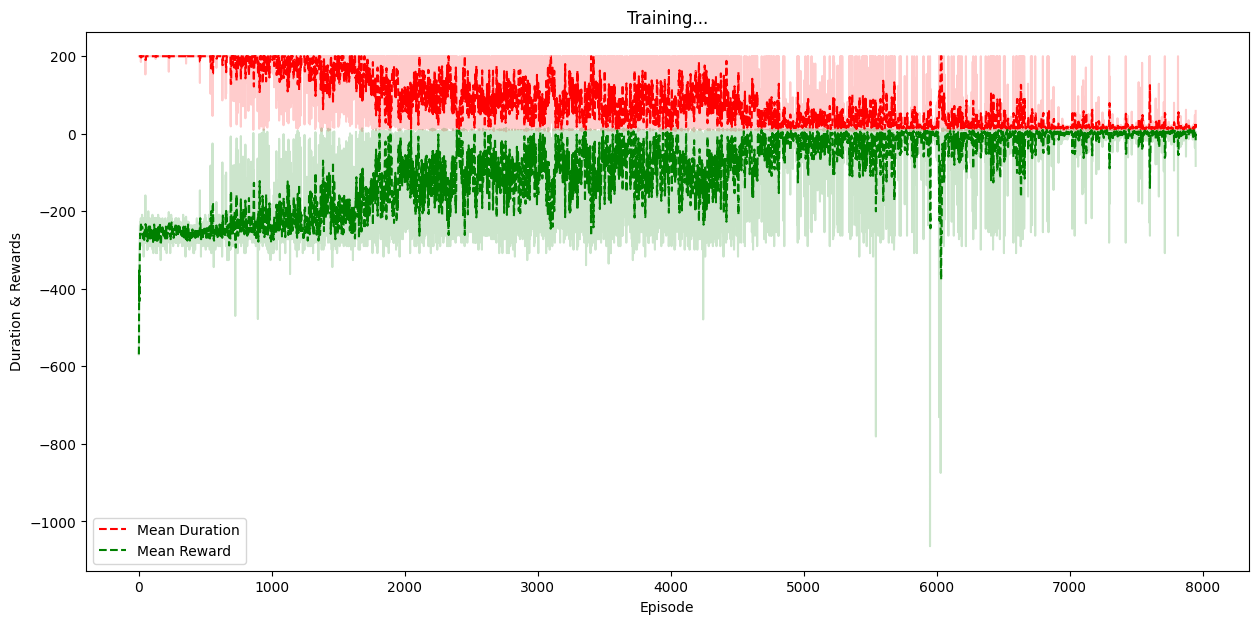

In [15]:
if torch.cuda.is_available():
    num_episodes = 2000
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    reward_in_episode = 0
    
    for t in count():
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        reward_in_episode += reward
        # Store the transition in memory
        memory.push(
            torch.tensor([state], device=device), 
            torch.tensor([action], device=device, dtype=torch.long),
            torch.tensor([next_state], device=device), 
            torch.tensor([reward], device=device),
        )

        # Move to the next state
        done = terminated or truncated
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            reward_history.append(reward_in_episode)
            epsilons.append(EPS_END + (EPS_START - EPS_END) * math.exp(-i_episode / EPS_DECAY))
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations()
plt.ioff()
plt.show()

In [16]:
torch.save(policy_net.state_dict(), 'policy_net.pth')

In [12]:
checkpoint = torch.load('policy_net.pth')
policy_net.load_state_dict(checkpoint)

<All keys matched successfully>

In [16]:
actions_str = ["South", "North", "East", "West", "Pickup", "Dropoff"]

iteration = 0
state, info = env.reset()  # reset environment to a new, random state
env.render()
time.sleep(0.02)
terminated = False

while not terminated:
    action = get_action_for_state(state)
    iteration += 1
    state, reward, terminated, truncated, _ = env.step(action.item())
    display.clear_output(wait=True)
    print(env.render())
    print(f"Iter: {iteration} - Action: {action}({actions_str[action]}) - Reward {reward}")
    time.sleep(0.5)
    if iteration == 200:
        print("cannot converge :(")
        break

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iter: 12 - Action: tensor([5], device='cuda:0')(Dropoff) - Reward 20
